🔹 Cell 1 – Imports + Global Config

In [1]:
# ================== Cell 1: Imports + Global Config ==================

import os
import glob
import random
from collections import Counter
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --------- Random seed & device ---------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- Path dataset ---------
ROOT_DIR = r"E:\0.TA_Teguh\dataset2\hasil_torso_temporal"

# --------- Preprocessing config ---------
GAP_THRESHOLD_TRAIN = 5       # frame gap max sebelum segmen di-split
MIN_TORSO_POINTS    = 5       # frame valid minimal titik torso
WINDOW_LEN          = 40     # panjang window (frame)
WINDOW_STRIDE       = 1       # stride temporal (bisa nanti dicoba 4)
N_POINTS_TARGET     = 32      # titik per frame untuk PointNet
MIN_SEGMENT_LEN     = 10      # segmen minimal digunakan (frame)

# --------- Training config ---------
NUM_EPOCHS   = 60
PATIENCE     = 10
BASE_LR      = 3e-4
BASE_BS      = 16
NUM_CLASSES  = 3   # Afi, Tsamara, Tsania

# --------- HPO config (Random Search) ---------
DO_HPO       = True
HPO_TRIALS   = 35
HPO_EPOCHS   = 25 # epoch pendek untuk tiap trial

HPO_SPACE = {
    "lr":           [1e-3, 3e-4, 1e-4],
    "batch_size":   [8, 16],
    "pointnet_dim": [128, 256],
    "num_layers":   [1, 2, 3],
    "num_heads":    [2, 4],
    "dropout":      [0.0, 0.1, 0.2],
    "weight_decay": [0.0, 1e-4],
}

print("=== CONFIG ===")
print(f"ROOT_DIR           : {ROOT_DIR}")
print(f"DEVICE             : {DEVICE}")
print(f"WINDOW_LEN         : {WINDOW_LEN}")
print(f"WINDOW_STRIDE      : {WINDOW_STRIDE}")
print(f"N_POINTS_TARGET    : {N_POINTS_TARGET}")
print(f"GAP_THRESHOLD_TRAIN: {GAP_THRESHOLD_TRAIN}")
print(f"MIN_TORSO_POINTS   : {MIN_TORSO_POINTS}")
print(f"MIN_SEGMENT_LEN    : {MIN_SEGMENT_LEN}")
print(f"NUM_EPOCHS         : {NUM_EPOCHS}")
print(f"PATIENCE           : {PATIENCE}")
print(f"DO_HPO             : {DO_HPO} (trials={HPO_TRIALS}, epochs_per_trial={HPO_EPOCHS})")


=== CONFIG ===
ROOT_DIR           : E:\0.TA_Teguh\dataset2\hasil_torso_temporal
DEVICE             : cpu
WINDOW_LEN         : 40
WINDOW_STRIDE      : 1
N_POINTS_TARGET    : 32
GAP_THRESHOLD_TRAIN: 5
MIN_TORSO_POINTS   : 5
MIN_SEGMENT_LEN    : 10
NUM_EPOCHS         : 60
PATIENCE           : 10
DO_HPO             : True (trials=35, epochs_per_trial=25)


🔹 Cell 2 – Dataclass & Utility I/O

In [2]:
# ================== Cell 2: Dataclass & Utility I/O ==================

CSV_CACHE = {}  # cache df per file_path supaya tidak bolak-balik baca disk

@dataclass
class SampleMeta:
    file_path: str
    subject_id: str
    frame_ids: list  # list of frame numbers (panjang WINDOW_LEN)


def parse_subject_id_from_path(file_path: str) -> str:
    """
    Ambil nama folder sebagai subject_id, misal:
    ...\Afi\torsoT_Jalan53.csv -> 'Afi'
    """
    folder = os.path.basename(os.path.dirname(file_path))
    return folder


def load_torso_csv(file_path: str) -> pd.DataFrame:
    """
    Baca CSV torso. Cache di memori supaya akses lebih cepat.
    Expect minimal kolom: frame, x, y, z, doppler
    """
    if file_path in CSV_CACHE:
        return CSV_CACHE[file_path]

    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"File tidak ditemukan: {file_path}")

    df = pd.read_csv(file_path)

    required_cols = ["frame", "x", "y", "z", "doppler"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Kolom wajib hilang di {file_path}: {missing}")

    # Pastikan tipe numeric
    for col in required_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Drop baris dengan NaN di kolom utama
    df = df.dropna(subset=required_cols).reset_index(drop=True)

    CSV_CACHE[file_path] = df
    return df


print("SampleMeta, parse_subject_id_from_path, dan load_torso_csv sudah didefinisikan.")

# (Opsional) Tes kecil subject_id dari path contoh, kalau ada:
example_pattern = glob.glob(os.path.join(ROOT_DIR, "*", "torsoT_Jalan*.csv"))
if example_pattern:
    print("Contoh subject dari path:")
    print(" ", example_pattern[0], "->", parse_subject_id_from_path(example_pattern[0]))
else:
    print("Peringatan: belum ada file torsoT_Jalan*.csv yang ditemukan untuk contoh.")


SampleMeta, parse_subject_id_from_path, dan load_torso_csv sudah didefinisikan.
Contoh subject dari path:
  E:\0.TA_Teguh\dataset2\hasil_torso_temporal\Afi\torsoT_Jalan1.csv -> Afi


🔹 Cell 3 – Segmentasi Temporal (Gap & Frame Valid)

In [3]:
# ================== Cell 3: Segmentasi Temporal ==================

def build_segments_from_df(df: pd.DataFrame,
                           gap_threshold: int = GAP_THRESHOLD_TRAIN,
                           min_points: int = MIN_TORSO_POINTS,
                           min_segment_len: int = MIN_SEGMENT_LEN):
    """
    Dari df (frame, x, y, z, doppler) -> list segmen.
    Satu segmen = list frame_id yang valid dan kontinu (gap <= gap_threshold).
    Frame valid = punya >= min_points titik.
    """
    # Hitung jumlah titik per frame
    frame_counts = df.groupby("frame")["x"].count()
    valid_frames = sorted(frame_counts[frame_counts >= min_points].index.tolist())

    segments = []
    if not valid_frames:
        return segments

    current_seg = [valid_frames[0]]
    for f in valid_frames[1:]:
        if f - current_seg[-1] <= gap_threshold:
            current_seg.append(f)
        else:
            # Akhiri segmen sebelumnya
            if len(current_seg) >= min_segment_len:
                segments.append(current_seg)
            # mulai segmen baru
            current_seg = [f]

    # Segmen terakhir
    if len(current_seg) >= min_segment_len:
        segments.append(current_seg)

    return segments


print("Fungsi build_segments_from_df sudah didefinisikan.")

# (Opsional) Tes singkat dengan list frame dummy:
_dummy_frames = [1, 2, 3, 10, 11, 20, 21, 22, 23]
_dummy_df = pd.DataFrame({
    "frame": _dummy_frames,
    "x": np.random.randn(len(_dummy_frames)),
    "y": np.random.randn(len(_dummy_frames)),
    "z": np.random.randn(len(_dummy_frames)),
    "doppler": np.random.randn(len(_dummy_frames)),
})
# Duplikasikan baris supaya tiap frame punya > MIN_TORSO_POINTS
_dummy_df = pd.concat([_dummy_df] * (MIN_TORSO_POINTS + 1), ignore_index=True)

_dummy_segments = build_segments_from_df(_dummy_df, gap_threshold=3, min_points=MIN_TORSO_POINTS, min_segment_len=2)
print("Contoh segmentasi temporal dummy:", _dummy_segments)


Fungsi build_segments_from_df sudah didefinisikan.
Contoh segmentasi temporal dummy: [[1, 2, 3], [10, 11], [20, 21, 22, 23]]


🔹 Cell 4 – Windowing + Bootstrap Spasial & Temporal

In [4]:
# ================== Cell 4: Windowing + Bootstrap ==================

def bootstrap_points(points: np.ndarray, n_target: int = N_POINTS_TARGET) -> np.ndarray:
    """
    points: (N, C)  ->  (n_target, C)
    Downsample jika N > n_target, upsample (sampling with replacement) jika N < n_target.
    """
    if points.shape[0] == 0:
        # Kalau benar-benar kosong, isi nol
        return np.zeros((n_target, points.shape[1]), dtype=np.float32)

    if points.shape[0] == n_target:
        return points.astype(np.float32)

    idx = None
    if points.shape[0] > n_target:
        idx = np.random.choice(points.shape[0], size=n_target, replace=False)
    else:
        idx = np.random.choice(points.shape[0], size=n_target, replace=True)
    return points[idx].astype(np.float32)


def window_segment(segment_frames,
                   window_len: int = WINDOW_LEN,
                   window_stride: int = WINDOW_STRIDE,
                   min_len: int = MIN_SEGMENT_LEN):
    """
    segment_frames: list frame id (sudah valid & kontinu)
    Return: list window, tiap window = list frame id panjang window_len
    """
    frames = list(segment_frames)
    n = len(frames)
    windows = []

    if n >= window_len:
        # sliding window
        start = 0
        while start + window_len <= n:
            win = frames[start:start + window_len]
            windows.append(win)
            start += window_stride
    elif n >= min_len:
        # segmen pendek tapi cukup -> upsample frame ke window_len
        sampled_idx = np.random.choice(np.arange(n), size=window_len, replace=True)
        sampled_frames = [frames[i] for i in sampled_idx]
        sampled_frames = sorted(sampled_frames)
        windows.append(sampled_frames)

    return windows


def generate_samples_from_segments(df: pd.DataFrame,
                                   segments,
                                   file_path: str,
                                   subject_id: str):
    """
    Dari df + segmen -> list SampleMeta.
    """
    samples = []
    for seg in segments:
        seg_windows = window_segment(seg, window_len=WINDOW_LEN,
                                     window_stride=WINDOW_STRIDE,
                                     min_len=MIN_SEGMENT_LEN)
        for w in seg_windows:
            samples.append(SampleMeta(
                file_path=file_path,
                subject_id=subject_id,
                frame_ids=w
            ))
    return samples


print("Fungsi bootstrap_points, window_segment, dan generate_samples_from_segments sudah didefinisikan.")

# Tes kecil bootstrap:
_dummy_points = np.random.randn(10, 4)
_boot_32 = bootstrap_points(_dummy_points, n_target=32)
print("Contoh bootstrap_points: input (10,4) -> output", _boot_32.shape)


Fungsi bootstrap_points, window_segment, dan generate_samples_from_segments sudah didefinisikan.
Contoh bootstrap_points: input (10,4) -> output (32, 4)


🔹 Cell 5 – Build Samples dari Folder + PREPROCESS CHECK

In [5]:
# ================== Cell 5: Build Samples + PREPROCESS CHECK ==================

def build_samples_from_root(root_dir: str):
    """
    Scan semua subfolder (Afi, Tsamara, Tsania),
    cari torsoT_Jalan*.csv, lalu bangun SampleMeta untuk tiap window.
    """
    all_samples = []
    subject_ids = []

    # cari subfolder
    subj_folders = [d for d in glob.glob(os.path.join(root_dir, "*")) if os.path.isdir(d)]
    subj_folders = sorted(subj_folders)

    total_files = 0

    for subj_folder in subj_folders:
        subject_id = os.path.basename(subj_folder)
        pattern = os.path.join(subj_folder, "torsoT_Jalan*.csv")
        files = sorted(glob.glob(pattern))
        if not files:
            continue

        print(f"Proses subject {subject_id}: {len(files)} file.")
        for fpath in files:
            total_files += 1
            df = load_torso_csv(fpath)
            segments = build_segments_from_df(df,
                                              gap_threshold=GAP_THRESHOLD_TRAIN,
                                              min_points=MIN_TORSO_POINTS,
                                              min_segment_len=MIN_SEGMENT_LEN)
            samples = generate_samples_from_segments(df, segments, fpath, subject_id)
            all_samples.extend(samples)
            subject_ids.extend([subject_id] * len(samples))

    # mapping subject -> index kelas (di-sort biar stabil)
    unique_subjects = sorted(list(set(subject_ids)))
    subject_to_idx = {s: i for i, s in enumerate(unique_subjects)}

    return all_samples, subject_to_idx


all_samples, subject_to_idx = build_samples_from_root(ROOT_DIR)

print("\n=== SUMMARY SAMPLES (SETELAH WINDOWING) ===")
print(f"Total file ditemukan   : {len({s.file_path for s in all_samples})}")
print(f"Total window (samples) : {len(all_samples)}")

cnt_subject = Counter(s.subject_id for s in all_samples)
print("\nSamples per subject:")
for sid, n in cnt_subject.items():
    print(f"  {sid:8s} : {n}")

cnt_file = Counter(os.path.basename(s.file_path) for s in all_samples)
print("\nTop 10 trial dengan window terbanyak:")
for fname, n in sorted(cnt_file.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {fname:25s} : {n}")

frames_per_sample = [len(s.frame_ids) for s in all_samples]
print("\nPanjang frame per window (harus {WINDOW_LEN} semua):", set(frames_per_sample))

print("\nMapping subject_to_idx:")
for k, v in subject_to_idx.items():
    print(f"  {k:8s} -> {v}")


Proses subject Afi: 72 file.
Proses subject Tsamara: 72 file.
Proses subject Tsania: 72 file.

=== SUMMARY SAMPLES (SETELAH WINDOWING) ===
Total file ditemukan   : 216
Total window (samples) : 20156

Samples per subject:
  Afi      : 5350
  Tsamara  : 8335
  Tsania   : 6471

Top 10 trial dengan window terbanyak:
  torsoT_Jalan23.csv        : 1114
  torsoT_Jalan71.csv        : 1036
  torsoT_Jalan72.csv        : 975
  torsoT_Jalan47.csv        : 667
  torsoT_Jalan24.csv        : 650
  torsoT_Jalan63.csv        : 598
  torsoT_Jalan48.csv        : 597
  torsoT_Jalan15.csv        : 579
  torsoT_Jalan22.csv        : 564
  torsoT_Jalan16.csv        : 545

Panjang frame per window (harus {WINDOW_LEN} semua): {40}

Mapping subject_to_idx:
  Afi      -> 0
  Tsamara  -> 1
  Tsania   -> 2


🔹 Cell 6 – Dataset Class + Split Train/Val/Test + Augmentasi

In [6]:
# ================== Cell 6: Dataset Class + Split ==================

def split_samples_train_val_test(all_samples,
                                 test_size=0.2,
                                 val_size=0.2,
                                 random_state=SEED):
    """
    Split stratified berdasarkan subject_id.
    test_size & val_size proporsi dari total (misal 0.2 & 0.2).
    """
    labels = [s.subject_id for s in all_samples]

    # 1) Train+Val vs Test
    trainval_samples, test_samples = train_test_split(
        all_samples,
        test_size=test_size,
        stratify=labels,
        random_state=random_state
    )

    # 2) Train vs Val
    trainval_labels = [s.subject_id for s in trainval_samples]
    val_ratio = val_size / (1.0 - test_size)

    train_samples, val_samples = train_test_split(
        trainval_samples,
        test_size=val_ratio,
        stratify=trainval_labels,
        random_state=random_state + 1
    )

    return train_samples, val_samples, test_samples


class GaitDataset(Dataset):
    def __init__(self, samples, subject_to_idx, split="train"):
        self.samples = samples
        self.subject_to_idx = subject_to_idx
        self.split = split

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        meta: SampleMeta = self.samples[idx]
        df = load_torso_csv(meta.file_path)

        frames = meta.frame_ids
        # Untuk tiap frame, ambil titik [x,y,z,doppler], centroid-normalize, bootstrap
        all_frames_points = []

        for f in frames:
            df_f = df[df["frame"] == f]
            pts = df_f[["x", "y", "z", "doppler"]].values  # (N,4)

            if pts.shape[0] == 0:
                # fallback: frame kosong -> isi nol
                pts = np.zeros((N_POINTS_TARGET, 4), dtype=np.float32)
            else:
                # centroid normalize (x,y,z)
                centroid = pts[:, :3].mean(axis=0, keepdims=True)  # (1,3)
                pts[:, :3] = pts[:, :3] - centroid

                # bootstrap spasial
                pts = bootstrap_points(pts, n_target=N_POINTS_TARGET)  # (32,4)

            all_frames_points.append(pts)

        x = np.stack(all_frames_points, axis=0)  # (T=WINDOW_LEN, N=32, C=4)

        # augmentasi hanya untuk train
        if self.split == "train":
            x = self._augment(x)

        # ke tensor
        x_tensor = torch.from_numpy(x).float()  # (T, N, 4)
        y_idx = self.subject_to_idx[meta.subject_id]
        y_tensor = torch.tensor(y_idx, dtype=torch.long)

        return x_tensor, y_tensor

    def _augment(self, x: np.ndarray) -> np.ndarray:
        """
        x: (T, N, C=4), augment posisi & sedikit kecepatan (doppler).
        Augment ringan agar tidak merusak pola gait.
        """
        # jitter kecil di posisi
        pos_jitter = np.random.normal(loc=0.0, scale=0.01, size=x[..., :3].shape)  # (T,N,3)
        x[..., :3] += pos_jitter

        # scaling kecil
        scale = np.random.uniform(0.95, 1.05)
        x[..., :3] *= scale

        # point dropout kecil (random matikan sebagian titik)
        dropout_prob = 0.05
        mask = np.random.rand(*x[..., 0].shape) < dropout_prob  # (T,N)
        x[mask, :3] = 0.0  # nolkan posisi titik yang di-drop

        return x


# --------- Split & buat dataset ---------
samples_train, samples_val, samples_test = split_samples_train_val_test(
    all_samples,
    test_size=0.2,
    val_size=0.2,
    random_state=SEED
)

train_dataset = GaitDataset(samples_train, subject_to_idx, split="train")
val_dataset   = GaitDataset(samples_val,   subject_to_idx, split="val")
test_dataset  = GaitDataset(samples_test,  subject_to_idx, split="test")

print("=== DATASET SPLIT ===")
print(f"Total samples : {len(all_samples)}")
print(f"Train samples : {len(train_dataset)}")
print(f"Val samples   : {len(val_dataset)}")
print(f"Test samples  : {len(test_dataset)}")

print("\nMapping subject_to_idx:")
for k, v in subject_to_idx.items():
    print(f"  {k:8s} -> {v}")

print("\nDataset objek sudah dibuat: train_dataset, val_dataset, test_dataset.")


=== DATASET SPLIT ===
Total samples : 20156
Train samples : 12093
Val samples   : 4031
Test samples  : 4032

Mapping subject_to_idx:
  Afi      -> 0
  Tsamara  -> 1
  Tsania   -> 2

Dataset objek sudah dibuat: train_dataset, val_dataset, test_dataset.


🔹 Cell 7 – DATASET & BATCH SHAPE CHECK

In [7]:
# ================== Cell 7: DATASET & BATCH SHAPE CHECK ==================

tmp_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

x_batch, y_batch = next(iter(tmp_loader))

print("=== DATASET & BATCH CHECK ===")
print(f"Train samples : {len(train_dataset)}")
print(f"Val samples   : {len(val_dataset)}")
print(f"Test samples  : {len(test_dataset)}")
print("\nSatu batch contoh:")
print("  x_batch.shape :", x_batch.shape)  # harus [4, 32, 32, 4]
print("  y_batch       :", y_batch)


=== DATASET & BATCH CHECK ===
Train samples : 12093
Val samples   : 4031
Test samples  : 4032

Satu batch contoh:
  x_batch.shape : torch.Size([4, 40, 32, 4])
  y_batch       : tensor([0, 0, 2, 2])


🔹 Cell 8 – Model Definition (PointNetBackbone + PointNetTransformer)

In [8]:
# ================== Cell 8: Model Definition (PointNet + Transformer) ==================

class PointNetBackbone(nn.Module):
    def __init__(self, in_channels=4, pointnet_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, pointnet_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        """
        x: (B, T, N, C)
        Output: (B, T, pointnet_dim)
        """
        B, T, N, C = x.shape
        x = x.view(B * T, N, C)          # (B*T, N, C)
        x = self.mlp(x)                  # (B*T, N, D)
        x, _ = x.max(dim=1)              # global max pooling -> (B*T, D)
        x = x.view(B, T, -1)             # (B, T, D)
        return x


class PointNetTransformer(nn.Module):
    def __init__(self,
                 in_channels=4,
                 pointnet_dim=256,
                 num_classes=NUM_CLASSES,
                 num_layers=2,
                 num_heads=4,
                 dropout=0.1):
        super().__init__()
        self.backbone = PointNetBackbone(in_channels=in_channels,
                                         pointnet_dim=pointnet_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=pointnet_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(pointnet_dim, num_classes)

    def forward(self, x):
        """
        x: (B, T, N, C)
        """
        spatial_feats = self.backbone(x)          # (B, T, D)
        temporal_feats = self.transformer(spatial_feats)  # (B, T, D)
        pooled = temporal_feats.mean(dim=1)       # (B, D)
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)                  # (B, num_classes)
        return logits


# Tes model dengan dummy input
cfg_pointnet_dim = 256
cfg_num_layers   = 2
cfg_num_heads    = 4
cfg_dropout      = 0.1

model = PointNetTransformer(
    in_channels=4,
    pointnet_dim=cfg_pointnet_dim,
    num_classes=NUM_CLASSES,
    num_layers=cfg_num_layers,
    num_heads=cfg_num_heads,
    dropout=cfg_dropout
).to(DEVICE)

x_dummy = torch.randn(2, WINDOW_LEN, N_POINTS_TARGET, 4).to(DEVICE)
logits_dummy = model(x_dummy)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model PointNetTransformer berhasil dibuat.")
print(f"Jumlah parameter trainable: {num_params}")
print("Contoh input  x_dummy.shape :", x_dummy.shape)
print("Contoh output logits.shape  :", logits_dummy.shape)


Model PointNetTransformer berhasil dibuat.
Jumlah parameter trainable: 2672579
Contoh input  x_dummy.shape : torch.Size([2, 40, 32, 4])
Contoh output logits.shape  : torch.Size([2, 3])


🔹 Cell 9 – Train/Eval Utilities + EarlyStopping + tqdm

In [9]:
# ================== Cell 9: Train/Eval Utilities + EarlyStopping ==================

class EarlyStopping:
    def __init__(self, patience=10, mode="min", delta=0.0, path="best_model2.pth"):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.path = path

        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def step(self, metric, model):
        """
        metric: val_loss jika mode='min', atau val_acc jika mode='max'
        """
        if self.mode == "min":
            score = -metric
        else:
            score = metric

        if self.best_score is None:
            self.best_score = score
            torch.save(model.state_dict(), self.path)
            self.counter = 0
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            torch.save(model.state_dict(), self.path)
            self.counter = 0


def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch, max_epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Train {epoch}/{max_epoch}", leave=False)
    for x, y in loop:
        x = x.to(device)  # (B, T, N, C)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / total if total > 0 else 0.0
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc


def eval_one_epoch(model, dataloader, criterion, device, desc="Val"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    loop = tqdm(dataloader, desc=desc, leave=False)
    with torch.no_grad():
        for x, y in loop:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    avg_loss = running_loss / total if total > 0 else 0.0
    acc = correct / total if total > 0 else 0.0
    if all_preds:
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
    else:
        all_preds = np.array([])
        all_labels = np.array([])

    return avg_loss, acc, all_preds, all_labels


def evaluate_on_test(model, test_loader, criterion, device):
    test_loss, test_acc, preds, labels = eval_one_epoch(
        model, test_loader, criterion, device, desc="Test"
    )
    return test_loss, test_acc, preds, labels


print("Fungsi train_one_epoch, eval_one_epoch, evaluate_on_test, dan EarlyStopping siap digunakan.")
print("Progress bar akan muncul saat training dan validation berjalan.")


Fungsi train_one_epoch, eval_one_epoch, evaluate_on_test, dan EarlyStopping siap digunakan.
Progress bar akan muncul saat training dan validation berjalan.


🔹 Cell 10 – HPO Random Search

In [10]:
# ================== Cell 10: HPO Random Search (Opsional) ==================

def sample_random_config():
    cfg = {
        "lr":           random.choice(HPO_SPACE["lr"]),
        "batch_size":   random.choice(HPO_SPACE["batch_size"]),
        "pointnet_dim": random.choice(HPO_SPACE["pointnet_dim"]),
        "num_layers":   random.choice(HPO_SPACE["num_layers"]),
        "num_heads":    random.choice(HPO_SPACE["num_heads"]),
        "dropout":      random.choice(HPO_SPACE["dropout"]),
        "weight_decay": random.choice(HPO_SPACE["weight_decay"]),
    }
    return cfg


def run_hpo_trial(cfg, trial_idx, total_trials):
    print(f"\n=== HPO TRIAL {trial_idx+1}/{total_trials} ===")
    print("Config:", cfg)

    # Build model
    model_hpo = PointNetTransformer(
        in_channels=4,
        pointnet_dim=cfg["pointnet_dim"],
        num_classes=NUM_CLASSES,
        num_layers=cfg["num_layers"],
        num_heads=cfg["num_heads"],
        dropout=cfg["dropout"]
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model_hpo.parameters(),
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"]
    )

    # Dataloader
    train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset,   batch_size=cfg["batch_size"], shuffle=False, num_workers=0)

    best_val_acc = 0.0

    for epoch in range(1, HPO_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(
            model_hpo, train_loader, optimizer, criterion, DEVICE, epoch, HPO_EPOCHS
        )
        val_loss, val_acc, _, _ = eval_one_epoch(
            model_hpo, val_loader, criterion, DEVICE, desc=f"Val (HPO e{epoch}/{HPO_EPOCHS})"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"[HPO Trial {trial_idx+1}] Epoch {epoch}/{HPO_EPOCHS} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print(f"Best Val Acc (Trial {trial_idx+1}): {best_val_acc:.4f}")
    return best_val_acc


best_cfg = {
    "lr":           BASE_LR,
    "batch_size":   BASE_BS,
    "pointnet_dim": 256,
    "num_layers":   2,
    "num_heads":    4,
    "dropout":      0.1,
    "weight_decay": 1e-4,
}

if DO_HPO:
    hpo_results = []
    for i in range(HPO_TRIALS):
        cfg = sample_random_config()
        score = run_hpo_trial(cfg, i, HPO_TRIALS)
        hpo_results.append((score, cfg))

    # sort descending by val_acc
    hpo_results.sort(key=lambda x: x[0], reverse=True)
    print("\n=== HPO SUMMARY ===")
    for rank, (score, cfg) in enumerate(hpo_results[:3], start=1):
        print(f"Top {rank}: Val Acc={score:.4f}, cfg={cfg}")

    best_cfg = hpo_results[0][1]
    print("\nConfig terbaik disimpan di variabel best_cfg:", best_cfg)
else:
    print("HPO dimatikan (DO_HPO = False). Config training akan memakai best_cfg default:")
    print(best_cfg)



=== HPO TRIAL 1/35 ===
Config: {'lr': 0.0001, 'batch_size': 8, 'pointnet_dim': 128, 'num_layers': 3, 'num_heads': 4, 'dropout': 0.0, 'weight_decay': 0.0}


Train 1/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e1/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 1/25 | Train Loss: 0.8794, Train Acc: 0.5794, Val Loss: 0.6790, Val Acc: 0.7160


Train 2/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e2/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 2/25 | Train Loss: 0.4920, Train Acc: 0.7981, Val Loss: 0.3253, Val Acc: 0.8685


Train 3/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e3/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 3/25 | Train Loss: 0.2637, Train Acc: 0.8996, Val Loss: 0.1116, Val Acc: 0.9653


Train 4/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e4/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 4/25 | Train Loss: 0.1631, Train Acc: 0.9402, Val Loss: 0.4853, Val Acc: 0.8457


Train 5/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e5/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 5/25 | Train Loss: 0.1092, Train Acc: 0.9620, Val Loss: 0.0675, Val Acc: 0.9767


Train 6/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e6/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 6/25 | Train Loss: 0.0882, Train Acc: 0.9685, Val Loss: 0.0419, Val Acc: 0.9866


Train 7/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e7/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 7/25 | Train Loss: 0.0681, Train Acc: 0.9759, Val Loss: 0.0809, Val Acc: 0.9715


Train 8/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e8/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 8/25 | Train Loss: 0.0504, Train Acc: 0.9818, Val Loss: 0.2168, Val Acc: 0.9407


Train 9/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e9/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 9/25 | Train Loss: 0.0568, Train Acc: 0.9812, Val Loss: 0.0412, Val Acc: 0.9859


Train 10/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e10/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 10/25 | Train Loss: 0.0450, Train Acc: 0.9845, Val Loss: 0.0206, Val Acc: 0.9931


Train 11/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e11/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 11/25 | Train Loss: 0.0501, Train Acc: 0.9817, Val Loss: 0.0337, Val Acc: 0.9903


Train 12/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e12/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 12/25 | Train Loss: 0.0329, Train Acc: 0.9893, Val Loss: 0.0148, Val Acc: 0.9965


Train 13/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e13/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 13/25 | Train Loss: 0.0349, Train Acc: 0.9887, Val Loss: 0.0104, Val Acc: 0.9965


Train 14/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e14/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 14/25 | Train Loss: 0.0327, Train Acc: 0.9892, Val Loss: 0.0769, Val Acc: 0.9772


Train 15/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e15/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 15/25 | Train Loss: 0.0389, Train Acc: 0.9871, Val Loss: 0.0116, Val Acc: 0.9985


Train 16/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e16/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 16/25 | Train Loss: 0.0222, Train Acc: 0.9924, Val Loss: 0.0406, Val Acc: 0.9856


Train 17/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e17/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 17/25 | Train Loss: 0.0326, Train Acc: 0.9883, Val Loss: 0.0476, Val Acc: 0.9824


Train 18/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e18/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 18/25 | Train Loss: 0.0281, Train Acc: 0.9908, Val Loss: 0.0079, Val Acc: 0.9978


Train 19/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e19/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 19/25 | Train Loss: 0.0217, Train Acc: 0.9930, Val Loss: 0.0180, Val Acc: 0.9953


Train 20/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e20/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 20/25 | Train Loss: 0.0265, Train Acc: 0.9906, Val Loss: 0.0379, Val Acc: 0.9859


Train 21/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e21/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 21/25 | Train Loss: 0.0258, Train Acc: 0.9914, Val Loss: 0.0109, Val Acc: 0.9970


Train 22/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e22/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 22/25 | Train Loss: 0.0180, Train Acc: 0.9946, Val Loss: 0.0208, Val Acc: 0.9931


Train 23/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e23/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 23/25 | Train Loss: 0.0237, Train Acc: 0.9924, Val Loss: 0.0071, Val Acc: 0.9983


Train 24/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e24/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 24/25 | Train Loss: 0.0220, Train Acc: 0.9922, Val Loss: 0.0097, Val Acc: 0.9973


Train 25/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e25/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 1] Epoch 25/25 | Train Loss: 0.0175, Train Acc: 0.9939, Val Loss: 0.0256, Val Acc: 0.9901
Best Val Acc (Trial 1): 0.9985

=== HPO TRIAL 2/35 ===
Config: {'lr': 0.001, 'batch_size': 8, 'pointnet_dim': 128, 'num_layers': 3, 'num_heads': 4, 'dropout': 0.0, 'weight_decay': 0.0}


Train 1/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e1/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 1/25 | Train Loss: 1.0948, Train Acc: 0.3979, Val Loss: 1.0820, Val Acc: 0.4135


Train 2/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e2/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 2/25 | Train Loss: 1.0851, Train Acc: 0.4105, Val Loss: 1.0830, Val Acc: 0.4135


Train 3/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e3/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 3/25 | Train Loss: 1.0838, Train Acc: 0.4128, Val Loss: 1.0821, Val Acc: 0.4135


Train 4/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e4/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 4/25 | Train Loss: 1.0838, Train Acc: 0.4135, Val Loss: 1.0823, Val Acc: 0.4135


Train 5/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e5/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 5/25 | Train Loss: 1.0831, Train Acc: 0.4125, Val Loss: 1.0844, Val Acc: 0.4135


Train 6/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e6/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 6/25 | Train Loss: 1.0828, Train Acc: 0.4135, Val Loss: 1.0904, Val Acc: 0.4135


Train 7/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e7/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 7/25 | Train Loss: 1.0836, Train Acc: 0.4123, Val Loss: 1.0820, Val Acc: 0.4135


Train 8/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e8/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 8/25 | Train Loss: 1.0829, Train Acc: 0.4135, Val Loss: 1.0827, Val Acc: 0.4135


Train 9/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e9/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 9/25 | Train Loss: 1.0827, Train Acc: 0.4135, Val Loss: 1.0822, Val Acc: 0.4135


Train 10/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e10/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 10/25 | Train Loss: 1.0828, Train Acc: 0.4126, Val Loss: 1.0833, Val Acc: 0.4135


Train 11/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e11/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 11/25 | Train Loss: 1.0831, Train Acc: 0.4135, Val Loss: 1.0823, Val Acc: 0.4135


Train 12/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e12/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 12/25 | Train Loss: 1.0828, Train Acc: 0.4135, Val Loss: 1.0826, Val Acc: 0.4135


Train 13/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e13/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 13/25 | Train Loss: 1.0829, Train Acc: 0.4135, Val Loss: 1.0820, Val Acc: 0.4135


Train 14/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e14/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 14/25 | Train Loss: 1.0826, Train Acc: 0.4135, Val Loss: 1.0823, Val Acc: 0.4135


Train 15/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e15/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 15/25 | Train Loss: 1.0827, Train Acc: 0.4135, Val Loss: 1.0821, Val Acc: 0.4135


Train 16/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e16/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 16/25 | Train Loss: 1.0824, Train Acc: 0.4135, Val Loss: 1.0821, Val Acc: 0.4135


Train 17/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e17/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 17/25 | Train Loss: 1.0826, Train Acc: 0.4135, Val Loss: 1.0821, Val Acc: 0.4135


Train 18/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e18/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 18/25 | Train Loss: 1.0826, Train Acc: 0.4135, Val Loss: 1.0821, Val Acc: 0.4135


Train 19/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e19/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 19/25 | Train Loss: 1.0825, Train Acc: 0.4135, Val Loss: 1.0821, Val Acc: 0.4135


Train 20/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e20/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 20/25 | Train Loss: 1.0825, Train Acc: 0.4135, Val Loss: 1.0821, Val Acc: 0.4135


Train 21/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e21/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 21/25 | Train Loss: 1.0825, Train Acc: 0.4135, Val Loss: 1.0823, Val Acc: 0.4135


Train 22/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e22/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 22/25 | Train Loss: 1.0823, Train Acc: 0.4135, Val Loss: 1.0820, Val Acc: 0.4135


Train 23/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e23/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 23/25 | Train Loss: 1.0824, Train Acc: 0.4135, Val Loss: 1.0821, Val Acc: 0.4135


Train 24/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e24/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 24/25 | Train Loss: 1.0823, Train Acc: 0.4135, Val Loss: 1.0820, Val Acc: 0.4135


Train 25/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e25/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 2] Epoch 25/25 | Train Loss: 1.0822, Train Acc: 0.4135, Val Loss: 1.0821, Val Acc: 0.4135
Best Val Acc (Trial 2): 0.4135

=== HPO TRIAL 3/35 ===
Config: {'lr': 0.001, 'batch_size': 8, 'pointnet_dim': 128, 'num_layers': 3, 'num_heads': 2, 'dropout': 0.2, 'weight_decay': 0.0}


Train 1/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e1/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 3] Epoch 1/25 | Train Loss: 1.0902, Train Acc: 0.4094, Val Loss: 1.0864, Val Acc: 0.4135


Train 2/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e2/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 3] Epoch 2/25 | Train Loss: 1.0862, Train Acc: 0.4119, Val Loss: 1.0850, Val Acc: 0.4135


Train 3/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e3/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 3] Epoch 3/25 | Train Loss: 1.0844, Train Acc: 0.4120, Val Loss: 1.0866, Val Acc: 0.4135


Train 4/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e4/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 3] Epoch 4/25 | Train Loss: 1.0840, Train Acc: 0.4118, Val Loss: 1.0823, Val Acc: 0.4135


Train 5/25:   0%|          | 0/1512 [00:00<?, ?it/s]

Val (HPO e5/25):   0%|          | 0/504 [00:00<?, ?it/s]

[HPO Trial 3] Epoch 5/25 | Train Loss: 1.0843, Train Acc: 0.4134, Val Loss: 1.0826, Val Acc: 0.4135


Train 6/25:   0%|          | 0/1512 [00:00<?, ?it/s]

KeyboardInterrupt: 

🔹 Cell 11 – Training Final + Early Stopping + Save Model

In [11]:
# Gunakan best_cfg (dari HPO atau default)
print("=== TRAINING FINAL CONFIG ===")
print(best_cfg)


=== TRAINING FINAL CONFIG ===
{'lr': 0.0003, 'batch_size': 16, 'pointnet_dim': 256, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.1, 'weight_decay': 0.0001}


In [12]:
# ================== Cell 11: Training Final + Early Stopping + Save Model ==================

# Gunakan best_cfg (dari HPO atau default)
print("=== TRAINING FINAL CONFIG ===")
print(best_cfg)

model_final = PointNetTransformer(
    in_channels=4,
    pointnet_dim=best_cfg["pointnet_dim"],
    num_classes=NUM_CLASSES,
    num_layers=best_cfg["num_layers"],
    num_heads=best_cfg["num_heads"],
    dropout=best_cfg["dropout"]
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model_final.parameters(),
    lr=best_cfg["lr"],
    weight_decay=best_cfg["weight_decay"]
)

train_loader = DataLoader(train_dataset, batch_size=best_cfg["batch_size"], shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=best_cfg["batch_size"], shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=best_cfg["batch_size"], shuffle=False, num_workers=0)

early_stopper = EarlyStopping(patience=PATIENCE, mode="min", path="best_model2.pth")

history = {
    "train_loss": [],
    "val_loss":   [],
    "train_acc":  [],
    "val_acc":    [],
}

best_epoch     = 0
best_val_loss  = float("inf")
best_val_acc   = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n=== Epoch {epoch}/{NUM_EPOCHS} ===")

    train_loss, train_acc = train_one_epoch(
        model_final, train_loader, optimizer, criterion, DEVICE, epoch, NUM_EPOCHS
    )
    val_loss, val_acc, _, _ = eval_one_epoch(
        model_final, val_loader, criterion, DEVICE, desc=f"Val e{epoch}/{NUM_EPOCHS}"
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[Final] Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # update best epoch info
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc  = val_acc
        best_epoch    = epoch

    # early stopping by val_loss
    early_stopper.step(val_loss, model_final)
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Simpan snapshot last epoch (opsional)
torch.save(model_final.state_dict(), "last_epoch_model2.pth")

print("\n=== TRAINING FINAL SELESAI ===")
print(f"Total epoch dijalankan    : {epoch}")
print(f"Best epoch (val loss)     : {best_epoch}")
print(f"Best val loss             : {best_val_loss:.4f}")
print(f"Best val accuracy (epoch) : {best_val_acc:.4f}")
print("Model terbaik disimpan ke : best_model2.pth")
print("Snapshot last epoch ke    : last_epoch_model.pth")

# Load kembali best model sebelum evaluasi test
model_final.load_state_dict(torch.load("best_model2.pth", map_location=DEVICE))
model_final.to(DEVICE)
model_final.eval()


=== TRAINING FINAL CONFIG ===
{'lr': 0.0003, 'batch_size': 16, 'pointnet_dim': 256, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.1, 'weight_decay': 0.0001}

=== Epoch 1/60 ===


Train 1/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e1/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 1/60 | Train Loss: 0.9718, Train Acc: 0.5304 | Val Loss: 0.6862, Val Acc: 0.7050

=== Epoch 2/60 ===


Train 2/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e2/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 2/60 | Train Loss: 0.5672, Train Acc: 0.7591 | Val Loss: 0.4100, Val Acc: 0.8340

=== Epoch 3/60 ===


Train 3/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e3/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 3/60 | Train Loss: 0.3406, Train Acc: 0.8688 | Val Loss: 0.2175, Val Acc: 0.9174

=== Epoch 4/60 ===


Train 4/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e4/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 4/60 | Train Loss: 0.2184, Train Acc: 0.9178 | Val Loss: 0.1081, Val Acc: 0.9638

=== Epoch 5/60 ===


Train 5/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e5/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 5/60 | Train Loss: 0.1446, Train Acc: 0.9477 | Val Loss: 0.1064, Val Acc: 0.9655

=== Epoch 6/60 ===


Train 6/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e6/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 6/60 | Train Loss: 0.1163, Train Acc: 0.9586 | Val Loss: 0.0737, Val Acc: 0.9757

=== Epoch 7/60 ===


Train 7/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e7/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 7/60 | Train Loss: 0.1012, Train Acc: 0.9660 | Val Loss: 0.1706, Val Acc: 0.9412

=== Epoch 8/60 ===


Train 8/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e8/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 8/60 | Train Loss: 0.0783, Train Acc: 0.9732 | Val Loss: 0.0583, Val Acc: 0.9809

=== Epoch 9/60 ===


Train 9/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e9/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 9/60 | Train Loss: 0.0798, Train Acc: 0.9706 | Val Loss: 0.0527, Val Acc: 0.9826

=== Epoch 10/60 ===


Train 10/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e10/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 10/60 | Train Loss: 0.0615, Train Acc: 0.9786 | Val Loss: 0.0608, Val Acc: 0.9794

=== Epoch 11/60 ===


Train 11/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e11/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 11/60 | Train Loss: 0.0653, Train Acc: 0.9768 | Val Loss: 0.0502, Val Acc: 0.9829

=== Epoch 12/60 ===


Train 12/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e12/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 12/60 | Train Loss: 0.0574, Train Acc: 0.9808 | Val Loss: 0.0282, Val Acc: 0.9903

=== Epoch 13/60 ===


Train 13/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e13/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 13/60 | Train Loss: 0.0531, Train Acc: 0.9818 | Val Loss: 0.3897, Val Acc: 0.8839

=== Epoch 14/60 ===


Train 14/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e14/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 14/60 | Train Loss: 0.0499, Train Acc: 0.9839 | Val Loss: 0.0935, Val Acc: 0.9655

=== Epoch 15/60 ===


Train 15/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e15/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 15/60 | Train Loss: 0.0444, Train Acc: 0.9836 | Val Loss: 0.0394, Val Acc: 0.9881

=== Epoch 16/60 ===


Train 16/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e16/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 16/60 | Train Loss: 0.0501, Train Acc: 0.9824 | Val Loss: 0.0441, Val Acc: 0.9856

=== Epoch 17/60 ===


Train 17/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e17/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 17/60 | Train Loss: 0.0348, Train Acc: 0.9873 | Val Loss: 0.0244, Val Acc: 0.9923

=== Epoch 18/60 ===


Train 18/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e18/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 18/60 | Train Loss: 0.0463, Train Acc: 0.9845 | Val Loss: 0.0294, Val Acc: 0.9906

=== Epoch 19/60 ===


Train 19/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e19/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 19/60 | Train Loss: 0.0416, Train Acc: 0.9863 | Val Loss: 0.1702, Val Acc: 0.9472

=== Epoch 20/60 ===


Train 20/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e20/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 20/60 | Train Loss: 0.0443, Train Acc: 0.9852 | Val Loss: 0.0363, Val Acc: 0.9881

=== Epoch 21/60 ===


Train 21/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e21/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 21/60 | Train Loss: 0.0303, Train Acc: 0.9893 | Val Loss: 0.0696, Val Acc: 0.9764

=== Epoch 22/60 ===


Train 22/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e22/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 22/60 | Train Loss: 0.0363, Train Acc: 0.9872 | Val Loss: 0.0299, Val Acc: 0.9911

=== Epoch 23/60 ===


Train 23/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e23/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 23/60 | Train Loss: 0.0297, Train Acc: 0.9912 | Val Loss: 0.0210, Val Acc: 0.9938

=== Epoch 24/60 ===


Train 24/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e24/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 24/60 | Train Loss: 0.0428, Train Acc: 0.9855 | Val Loss: 0.0099, Val Acc: 0.9965

=== Epoch 25/60 ===


Train 25/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e25/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 25/60 | Train Loss: 0.0360, Train Acc: 0.9890 | Val Loss: 0.0322, Val Acc: 0.9886

=== Epoch 26/60 ===


Train 26/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e26/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 26/60 | Train Loss: 0.0326, Train Acc: 0.9888 | Val Loss: 0.0652, Val Acc: 0.9799

=== Epoch 27/60 ===


Train 27/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e27/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 27/60 | Train Loss: 0.0279, Train Acc: 0.9916 | Val Loss: 0.0117, Val Acc: 0.9965

=== Epoch 28/60 ===


Train 28/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e28/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 28/60 | Train Loss: 0.0324, Train Acc: 0.9897 | Val Loss: 0.0301, Val Acc: 0.9888

=== Epoch 29/60 ===


Train 29/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e29/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 29/60 | Train Loss: 0.0238, Train Acc: 0.9907 | Val Loss: 0.0210, Val Acc: 0.9921

=== Epoch 30/60 ===


Train 30/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e30/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 30/60 | Train Loss: 0.0306, Train Acc: 0.9891 | Val Loss: 0.0165, Val Acc: 0.9960

=== Epoch 31/60 ===


Train 31/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e31/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 31/60 | Train Loss: 0.0225, Train Acc: 0.9930 | Val Loss: 0.0302, Val Acc: 0.9911

=== Epoch 32/60 ===


Train 32/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e32/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 32/60 | Train Loss: 0.0341, Train Acc: 0.9885 | Val Loss: 0.0347, Val Acc: 0.9888

=== Epoch 33/60 ===


Train 33/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e33/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 33/60 | Train Loss: 0.0261, Train Acc: 0.9904 | Val Loss: 0.0164, Val Acc: 0.9960

=== Epoch 34/60 ===


Train 34/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e34/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 34/60 | Train Loss: 0.0231, Train Acc: 0.9913 | Val Loss: 0.0065, Val Acc: 0.9980

=== Epoch 35/60 ===


Train 35/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e35/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 35/60 | Train Loss: 0.0343, Train Acc: 0.9886 | Val Loss: 0.0153, Val Acc: 0.9933

=== Epoch 36/60 ===


Train 36/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e36/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 36/60 | Train Loss: 0.0224, Train Acc: 0.9918 | Val Loss: 0.0991, Val Acc: 0.9670

=== Epoch 37/60 ===


Train 37/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e37/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 37/60 | Train Loss: 0.0247, Train Acc: 0.9910 | Val Loss: 0.0558, Val Acc: 0.9829

=== Epoch 38/60 ===


Train 38/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e38/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 38/60 | Train Loss: 0.0256, Train Acc: 0.9908 | Val Loss: 0.0546, Val Acc: 0.9824

=== Epoch 39/60 ===


Train 39/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e39/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 39/60 | Train Loss: 0.0194, Train Acc: 0.9937 | Val Loss: 0.0122, Val Acc: 0.9965

=== Epoch 40/60 ===


Train 40/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e40/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 40/60 | Train Loss: 0.0250, Train Acc: 0.9920 | Val Loss: 0.0271, Val Acc: 0.9926

=== Epoch 41/60 ===


Train 41/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e41/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 41/60 | Train Loss: 0.0228, Train Acc: 0.9921 | Val Loss: 0.0073, Val Acc: 0.9965

=== Epoch 42/60 ===


Train 42/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e42/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 42/60 | Train Loss: 0.0268, Train Acc: 0.9901 | Val Loss: 0.0086, Val Acc: 0.9963

=== Epoch 43/60 ===


Train 43/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e43/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 43/60 | Train Loss: 0.0258, Train Acc: 0.9911 | Val Loss: 0.0198, Val Acc: 0.9943

=== Epoch 44/60 ===


Train 44/60:   0%|          | 0/756 [00:00<?, ?it/s]

Val e44/60:   0%|          | 0/252 [00:00<?, ?it/s]

[Final] Epoch 44/60 | Train Loss: 0.0189, Train Acc: 0.9935 | Val Loss: 0.0078, Val Acc: 0.9965
Early stopping triggered at epoch 44.

=== TRAINING FINAL SELESAI ===
Total epoch dijalankan    : 44
Best epoch (val loss)     : 34
Best val loss             : 0.0065
Best val accuracy (epoch) : 0.9980
Model terbaik disimpan ke : best_model2.pth
Snapshot last epoch ke    : last_epoch_model.pth


PointNetTransformer(
  (backbone): PointNetBackbone(
    (mlp): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=256, bias=True)
      (5): ReLU()
    )
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p

🔹 Cell 12 – Plot Kurva & Evaluasi Test

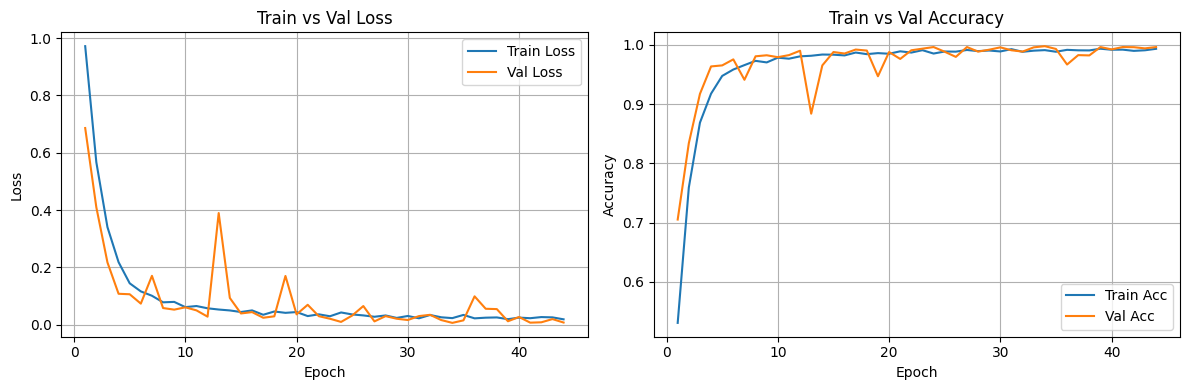

Test:   0%|          | 0/252 [00:00<?, ?it/s]


=== TEST RESULT ===
Test Loss: 0.0079, Test Acc: 0.9978

Classification report per subject:
              precision    recall  f1-score   support

         Afi     0.9963    1.0000    0.9981      1070
     Tsamara     1.0000    0.9970    0.9985      1667
      Tsania     0.9961    0.9969    0.9965      1295

    accuracy                         0.9978      4032
   macro avg     0.9975    0.9980    0.9977      4032
weighted avg     0.9978    0.9978    0.9978      4032

Confusion matrix:
[[1070    0    0]
 [   0 1662    5]
 [   4    0 1291]]

Macro F1     : 0.9977
Weighted F1  : 0.9978


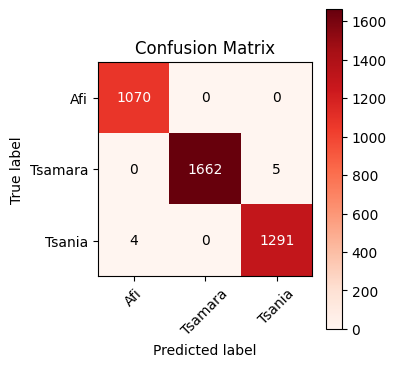

In [13]:
# ================== Cell 12: Plot Kurva & Evaluasi Test ==================

# ---- Plot kurva loss & accuracy ----
epochs_ran = len(history["train_loss"])
x_epochs = range(1, epochs_ran + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, history["train_loss"], label="Train Loss")
plt.plot(x_epochs, history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_epochs, history["train_acc"], label="Train Acc")
plt.plot(x_epochs, history["val_acc"],   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ---- Evaluasi Test ----
test_loss, test_acc, test_preds, test_labels = evaluate_on_test(
    model_final, test_loader, criterion, DEVICE
)

print("\n=== TEST RESULT ===")
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

if test_preds.size > 0:
    # classification report
    idx_to_subject = {v: k for k, v in subject_to_idx.items()}
    target_names = [idx_to_subject[i] for i in range(NUM_CLASSES)]

    print("\nClassification report per subject:")
    print(classification_report(test_labels, test_preds, target_names=target_names, digits=4))

    # confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print("Confusion matrix:")
    print(cm)

    macro_f1    = f1_score(test_labels, test_preds, average="macro")
    weighted_f1 = f1_score(test_labels, test_preds, average="weighted")
    print(f"\nMacro F1     : {macro_f1:.4f}")
    print(f"Weighted F1  : {weighted_f1:.4f}")

    # plot confusion matrix
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)   # Ini yang diubah jadi merah ya Teguh 
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada prediksi test (test set kosong?).")
